<a href="https://colab.research.google.com/github/AbidHasan04/Pencilmenship/blob/main/cycleGANStudentandAdaIN2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!rm -r ~/.kaggle

rm: cannot remove '/root/.kaggle': No such file or directory


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle

In [6]:
! chmod 600 /content/drive/MyDrive/kaggle.json ~/.kaggle

In [7]:
! kaggle datasets download wuhecong/danbooru-sketch-pair-128x

Dataset URL: https://www.kaggle.com/datasets/wuhecong/danbooru-sketch-pair-128x
License(s): ODbL-1.0
100% 9.71G/9.71G [08:43<00:00, 22.7MB/s]
100% 9.71G/9.71G [08:43<00:00, 19.9MB/s]


In [8]:
! unzip /content/danbooru-sketch-pair-128x.zip

Streaming output truncated to the last 5000 lines.
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2920130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2944130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2947130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2953130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2954130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2956130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/2962130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/304130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/315130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/343130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/346130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/364130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/373130.png  
  inflating: danbooru-sketch-pair-128x/gray/src/0130/407130.png  
  inflating: danbo

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torchvision import transforms
import matplotlib.pyplot as plt

from PIL import Image

import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [10]:
import torch.nn.functional as F

In [11]:
class AdaIN(nn.Module):
    def __init__(self, epsilon=1e-5):
        super(AdaIN, self).__init__()
        self.epsilon = epsilon

    def forward(self, content_features, style_features):
        # mean and variance for CONTENT and STYLE
        mean_content = content_features.mean(dim=[2, 3], keepdim=True)
        std_content = content_features.std(dim=[2, 3], keepdim=True) + self.epsilon
        mean_style = style_features.mean(dim=[2, 3], keepdim=True)
        std_style = style_features.std(dim=[2, 3], keepdim=True) + self.epsilon

        # Normalize
        normalized_features = (content_features - mean_content) / std_content
        stylized_features = (normalized_features * std_style) + mean_style

        return stylized_features


class ImageFullDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.painting_dir = os.path.join(root_dir, 'color/src/0002')
        self.sketch_dir = os.path.join(root_dir, 'color/sketch/0002')
        self.painting_files = sorted(os.listdir(self.painting_dir))
        self.sketch_files = sorted(os.listdir(self.sketch_dir))
        self.transform = transform

    def __len__(self):
        return len(self.painting_files)

    def __getitem__(self, idx):
        # Load the full image and sketch
        painting_path = os.path.join(self.painting_dir, self.painting_files[idx])
        sketch_path = os.path.join(self.sketch_dir, self.sketch_files[idx])
        painting = Image.open(painting_path).convert('RGB')
        sketch = Image.open(sketch_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            painting = self.transform(painting)
            sketch = self.transform(sketch)

        return {'painting': painting, 'sketch': sketch}


transform = transforms.Compose([
transforms.Resize((64, 64)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFullDataset(root_dir="/content/danbooru-sketch-pair-128x", transform=transform)
dataloader = DataLoader(dataset, batch_size= 64, shuffle=True)


In [37]:
class ImageFullDataset(Dataset):
    def __init__(self, root_dir, transform=None, dirs=['0001', '0002', '0006', '0007', '0008', '0009', '0010']):
        self.root_dir = root_dir
        self.transform = transform
        self.dirs = dirs
        self.datasets = []

        for dir in dirs:
            painting_dir = os.path.join(root_dir, 'color/src', dir)
            sketch_dir = os.path.join(root_dir, 'color/sketch', dir)
            painting_files = sorted(os.listdir(painting_dir))
            sketch_files = sorted(os.listdir(sketch_dir))
            self.datasets.append({
                'painting_dir': painting_dir,
                'sketch_dir': sketch_dir,
                'painting_files': painting_files,
                'sketch_files': sketch_files
            })

    def __len__(self):
        return sum(len(dataset['painting_files']) for dataset in self.datasets)

    def __getitem__(self, idx):
        # Determine which dataset to use based on the index
        dataset_idx = 0
        total_len = 0
        while idx >= total_len:
            total_len += len(self.datasets[dataset_idx]['painting_files'])
            dataset_idx += 1

        dataset_idx -= 1
        painting_idx = idx - total_len + len(self.datasets[dataset_idx]['painting_files']) - 1

        # Load the full image and sketch
        painting_path = os.path.join(self.datasets[dataset_idx]['painting_dir'], self.datasets[dataset_idx]['painting_files'][painting_idx])
        sketch_path = os.path.join(self.datasets[dataset_idx]['sketch_dir'], self.datasets[dataset_idx]['sketch_files'][painting_idx])
        painting = Image.open(painting_path).convert('RGB')
        sketch = Image.open(sketch_path).convert('RGB')

        # Apply transformations if any
        if self.transform:
            painting = self.transform(painting)
            sketch = self.transform(sketch)

        return {'painting': painting, 'sketch': sketch}


transform = transforms.Compose([
transforms.Resize((64, 64)),
transforms.ToTensor(),
transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = ImageFullDataset(root_dir="/content/danbooru-sketch-pair-128x", transform=transform)
dataloader = DataLoader(dataset, batch_size= 128, shuffle=True)



##Building BLOCKS

In [13]:
sharpening_filter = torch.tensor([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
], dtype=torch.float32)

point_spread_filter = torch.tensor([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
], dtype=torch.float32)

gradient_north_filter = torch.tensor([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
], dtype=torch.float32)

gradient_north_east_filter = torch.tensor([
    [0, 1, 1],
    [-1, 0, 1],
    [-1, -1, 0]
], dtype=torch.float32)

gradient_north_west_filter = torch.tensor([
    [1, 1, 0],
    [1, 0, -1],
    [0, -1, -1]
], dtype=torch.float32)

gradient_south_filter = torch.tensor([
    [-1, -1, -1],
    [0, 0, 0],
    [1, 1, 1]
], dtype=torch.float32)

gradient_west_filter = torch.tensor([
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
], dtype=torch.float32)

# Create a function to apply a custom filter
class CustomFilterLayer(nn.Module):
    def __init__(self, kernel):
        super(CustomFilterLayer, self).__init__()
        self.kernel = kernel.view(1, 1, 3, 3)  # Reshape kernel for 2D conv

    def forward(self, x):
        # Ensure input is in the correct shape (Batch, Channels, Height, Width)
        return F.conv2d(x, self.kernel, padding=1)  # Apply convolution with padding






In [14]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        if 'kernel_size' not in kwargs: kwargs['kernel_size'] = 3 # ~!!!!Default kernel size if 'padding' not in kwargs: kwargs['padding'] = 1 # Default padding
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, padding_mode='reflect', **kwargs) if down
            else nn.ConvTranspose2d(in_channels, out_channels, **kwargs),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True) if use_act else nn.Identity()
        )

    def forward(self, x):
        return self.conv(x)




class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            ConvBlock(channels, channels, kernel_size=3, padding=1),
            ConvBlock(channels, channels, use_act=False, kernel_size=3, padding=1)
        )

    def forward(self, x):
        return x + self.block(x)


In [15]:
class GeneratorTeach(nn.Module):
    def __init__(self, img_channels, num_residuals=9, num_features=64):
        super().__init__()

        #encoder
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
        self.down_blocks = nn.ModuleList([
            ConvBlock(num_features, num_features * 2, kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features * 2, num_features * 4, kernel_size=3, stride=2, padding=1)
        ])


        self.adain = AdaIN()

        #decoder
        self.residual_blocks = nn.Sequential(*[ResidualBlock(num_features * 4) for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList([
            ConvBlock(num_features * 4, num_features * 2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features * 2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
        ])
        self.lastBlock = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")










    def forward(self, x, style_image):
        # Process both x and style_image through the initial layer
        x = self.initial(x)
        style_features = self.initial(style_image)  # Process style_image through the same initial layer

        # Downsample content and style features
        for layer in self.down_blocks:
            x = layer(x)
            style_features = layer(style_features)

       # print("x shape after downsampling:", x.shape)
        #print("style_features shape after downsampling:", style_features.shape)

        # Apply AdaIN
        x = self.residual_blocks(x)
        x = self.adain(x, style_features)

       # for filter_name in self.filters.keys():
        #  x = self.apply_filter(x, filter_name)  # Apply the current filter



        # Upsampling
        for layer in self.up_blocks:
            x = layer(x)

        return torch.tanh(self.lastBlock(x))




In [16]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(in_channels, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect"),
            nn.LeakyReLU(0.2)
        )
        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(ConvBlock(in_channels, feature, stride=1 if feature == features[-1] else 2))
            in_channels = feature
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))


#Student

In [17]:
class GeneratorStudent(nn.Module):
    def __init__(self, img_channels, num_residuals=6, num_features=32):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(img_channels, num_features, kernel_size=7, stride=1, padding=3, padding_mode="reflect"),
            nn.ReLU(inplace=True)
        )
        self.down_blocks = nn.ModuleList([
            ConvBlock(num_features, num_features * 2, kernel_size=3, stride=2, padding=1),
            ConvBlock(num_features * 2, num_features * 4, kernel_size=3, stride=2, padding=1)
        ])


        self.adain = AdaIN()
        self.residual_blocks = nn.Sequential(*[ResidualBlock(num_features * 4) for _ in range(num_residuals)])
        self.up_blocks = nn.ModuleList([
            ConvBlock(num_features * 4, num_features * 2, down=False, kernel_size=3, stride=2, padding=1, output_padding=1),
            ConvBlock(num_features * 2, num_features, down=False, kernel_size=3, stride=2, padding=1, output_padding=1)
        ])
        self.lastBlock = nn.Conv2d(num_features, img_channels, kernel_size=7, stride=1, padding=3, padding_mode="reflect")


    def forward(self, x, style_image):

        x = self.initial(x)
        style_features = self.initial(style_image)

        # Downsample content and style features
        for layer in self.down_blocks:
            x = layer(x)
            style_features = layer(style_features)

       # print("x shape after downsampling:", x.shape)
        #print("style_features shape after downsampling:", style_features.shape)

        #AdaIN
        x = self.adain(x, style_features)
        x = self.residual_blocks(x)

        # Upsampling
        for layer in self.up_blocks:
            x = layer(x)

        return torch.tanh(self.lastBlock(x))




In [39]:
#device ='cpu'
device = torch.device("cuda")
G = GeneratorTeach(3).to(device)
G_sketch = GeneratorTeach(3).to(device)

DA = Discriminator(3).to(device)
DB = Discriminator(3).to(device)

opt_G = optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.999))
opt_G_sketch = optim.Adam(G_sketch.parameters(), lr=0.0005, betas=(0.5, 0.999))

opt_DA = optim.Adam(DA.parameters(), lr=0.0005, betas=(0.5, 0.999))
opt_DB = optim.Adam(DB.parameters(), lr=0.0005, betas=(0.5, 0.999))

adversarial_loss = nn.BCEWithLogitsLoss()

cycle_loss = nn.MSELoss()
identity_loss = nn.MSELoss()
feature_matching_loss = nn.MSELoss()

In [19]:
def save_checkpoint(epoch, G, G_sketch, DA, DB, opt_F, opt_G_sketch, opt_DA, opt_DB, path):
    checkpoint = {
        'epoch': epoch,
        'G_state_dict': G.state_dict(),
        'G_sketch_state_dict': G_sketch.state_dict(),

        'Discriminator_A_state_dict': DA.state_dict(),
        'Discriminator_B_state_dict': DB.state_dict(),

        'optimizer_G_state_dict': opt_G.state_dict(),
        'optimizer_G_sketch_state_dict': opt_G_sketch.state_dict(),

        'optimizer_DA_state_dict': opt_DA.state_dict(),
        'optimizer_DB_state_dict': opt_DB.state_dict(),
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved for epoch {epoch}.")

In [40]:


def load_checkpoint( G, G_sketch, DA, DB, opt_F, opt_G_sketch, opt_DA, opt_DB, path):
    checkpoint = torch.load(path)
    G.load_state_dict(checkpoint['G_state_dict'])
    G_sketch.load_state_dict(checkpoint['G_sketch_state_dict'])

    DA.load_state_dict(checkpoint['Discriminator_A_state_dict'])
    DB.load_state_dict(checkpoint['Discriminator_B_state_dict'])

    opt_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    opt_G_sketch.load_state_dict(checkpoint['optimizer_G_sketch_state_dict'])

    opt_DA.load_state_dict(checkpoint['optimizer_DA_state_dict'])
    opt_DB.load_state_dict(checkpoint['optimizer_DB_state_dict'])
    start_epoch = checkpoint['epoch']   # Resume from the next epoch
    print(f"Checkpoint loaded. Resuming from epoch {start_epoch+1}.")
    return start_epoch+1


In [41]:

start_epoch = 0
num_epochs = 100  # Set your desired number of epochs
lambda_cycle = 18  # Weight for cycle consistency loss
lambda_identity = 0.55  # Weight for identity loss
lambda_feature_matching = 2 # Adjust as necessary
try:
    start_epoch = load_checkpoint(G, G_sketch, DA, DB, opt_G, opt_G_sketch, opt_DA, opt_DB, "/content/drive/MyDrive/checkpoint_epoch_9.pth")
except FileNotFoundError:
    print("Checkpoint not found. Starting training from epoch 0.")
for epoch in range(start_epoch, num_epochs):



    for batch in dataloader:
        painting = batch['painting'].to(device)
        sketch = batch['sketch'].to(device)

        # === Train Generators ===
        # Identity loss
        # G(painting) should be close to painting if painting is fed as input
        identity_painting = G(painting, sketch)
        loss_identity_painting = identity_loss(identity_painting, painting) * lambda_identity

        # G_sketch(sketch) should be close to sketch if sketch is fed as input
        identity_sketch = G_sketch(sketch, painting)
        loss_identity_sketch = identity_loss(identity_sketch, sketch) * lambda_identity

        # Adversarial loss
        fake_sketch = G(painting, sketch)
        pred_fake_sketch = DB(fake_sketch)
        loss_G_adv = adversarial_loss(pred_fake_sketch, torch.ones_like(pred_fake_sketch))

        fake_painting = G_sketch(sketch, painting)
        pred_fake_painting = DA(fake_painting)
        loss_F_adv = adversarial_loss(pred_fake_painting, torch.ones_like(pred_fake_painting))

        # Cycle consistency loss
        reconstructed_painting = G_sketch(fake_sketch, fake_painting)
        loss_cycle_painting = cycle_loss(reconstructed_painting, painting) * lambda_cycle

        reconstructed_sketch = G(fake_painting, fake_sketch)
        loss_cycle_sketch = cycle_loss(reconstructed_sketch, sketch) * lambda_cycle


        real_features = DA(sketch)
        fake_features = DB(fake_sketch)
        loss_feature_matching = feature_matching_loss(real_features, fake_features) * lambda_feature_matching


        # Total generator loss
        loss_G_total = loss_identity_painting + loss_identity_sketch + loss_G_adv + loss_F_adv + loss_cycle_painting + loss_cycle_sketch + loss_feature_matching

           # Clear gradients for the optimizers
        opt_G.zero_grad()
        opt_G_sketch.zero_grad()

        # Backpropagate total loss
        loss_G_total.backward()
        opt_G.step()
        opt_G_sketch.step()
        #xm.optimizer_step(opt_G)
        #xm.optimizer_step(opt_G_sketch)



        pred_real_painting = DA(painting)
        loss_DA_real = adversarial_loss(pred_real_painting, torch.ones_like(pred_real_painting))

        # Fake loss for DA
        pred_fake_painting = DA(fake_painting.detach())  # Detach to avoid updating G_sketch
        loss_DA_fake = adversarial_loss(pred_fake_painting, torch.zeros_like(pred_fake_painting))

        # Total loss for DA
        loss_DA = (loss_DA_real + loss_DA_fake) * 0.5

        # Real loss for DB
        pred_real_sketch = DB(sketch)
        loss_DB_real = adversarial_loss(pred_real_sketch, torch.ones_like(pred_real_sketch))

        # Fake loss for DB
        pred_fake_sketch = DB(fake_sketch.detach())  # Detach to avoid updating G
        loss_DB_fake = adversarial_loss(pred_fake_sketch, torch.zeros_like(pred_fake_sketch))

        # Total loss for DB
        loss_DB = (loss_DB_real + loss_DB_fake) * 0.5

        # Clear gradients for the discriminator optimizers
        opt_DA.zero_grad()
        opt_DB.zero_grad()

        # Backpropagate discriminator losses and update
        loss_DA.backward()
        opt_DA.step()
        #xm.optimizer_step(opt_DA)

        loss_DB.backward()
        opt_DB.step()
        #xm.optimizer_step(opt_DB)

        #m.save({
         #   'epoch': epoch,
            #'model_state_dict_G': G.state_dict(),
          #  'model_state_dict_G_sketch': G_sketch.state_dict(),
           # 'optimizer_state_dict_G': opt_G.state_dict(),
            #'optimizer_state_dict_G_sketch': opt_G_sketch.state_dict(),
            #'loss': loss_G_total,
            #'model_state_dict_DA': DA.state_dict(),
            #'model_state_dict_DB': DB.state_dict(),
            #'optimizer_state_dict_DA': opt_DA.state_dict(),
            #'optimizer_state_dict_DB': opt_DB.state_dict(),
            #'loss_DA': loss_DA,
            #'loss_DB': loss_DB
        #}, f"/content/drive/MyDrive/SavedEpochs/checkpoint_epoch_{epoch}.pth")


        save_checkpoint(epoch, G, G_sketch, DA, DB, opt_G, opt_G_sketch, opt_DA, opt_DB, "/content/drive/MyDrive/checkpoint_epoch_{}.pth".format(epoch))
        print(f"Epoch [{epoch}/{num_epochs}], Loss G_Total: {loss_G_total.item()}, Loss DA: {loss_DA.item()}, Loss DB: {loss_DB.item()}")

    print(f'Batch {batch} done')
print('Training done')

<ipython-input-40-bc7e12f18bb3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Checkpoint loaded. Resuming from epoch 10.


OutOfMemoryError: CUDA out of memory. Tried to allocate 42.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 37.06 MiB is free. Process 21787 has 14.71 GiB memory in use. Of the allocated memory 13.05 GiB is allocated by PyTorch, and 1.54 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

##StudentTraining

In [ ]:
distillation_loss = nn.MSELoss()
distillation_loss2 = nn.KLDivLoss()
lambda_distill = 10




In [ ]:
#G_teacher = GeneratorTeach(3).to(device)
G.load_state_dict(torch.load("/content/drive/MyDrive/SavedEpochs/checkpoint_epoch_11.pth")['G_state_dict'])
G.eval()  # Set to evaluation mode to prevent gradients from being computed

# Initialize student model, discriminators, and optimizers
G_student = GeneratorStudent(3).to(device)
opt_G_student = optim.Adam(G_student.parameters(), lr=0.0002, betas=(0.5, 0.999))
# Discriminators and their optimizers
DA = Discriminator(3).to(device)
DB = Discriminator(3).to(device)
opt_DA = optim.Adam(DA.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_DB = optim.Adam(DB.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
num_epochs = 20
lambda_cycle = 11  # Weight for cycle consistency loss
lambda_identity = 7
for epoch in range(num_epochs):
    for batch in dataloader:
        painting = batch['painting'].to(device)
        sketch = batch['sketch'].to(device)

        # === Forward pass through the frozen teacher models ===
        with torch.no_grad():
            teacher_fake_sketch = G(painting, sketch)
            teacher_fake_painting = G(sketch, painting)

        # === Forward pass through the student model ===
        student_fake_sketch = G_student(painting, sketch)
        student_fake_painting = G_student(sketch, painting)

        # === Distillation Loss ===
        distillation_loss_sketch = distillation_loss(student_fake_sketch, teacher_fake_sketch)
        distillation_loss_painting = distillation_loss(student_fake_painting, teacher_fake_painting)
        total_distillation_loss = (distillation_loss_sketch + distillation_loss_painting) * lambda_distill

        # === Identity Loss for Student ===
        identity_painting = G_student(painting, sketch)
        loss_identity_painting = identity_loss(identity_painting, painting) * lambda_identity
        identity_sketch = G_student(sketch, painting)
        loss_identity_sketch = identity_loss(identity_sketch, sketch) * lambda_identity

        # === Adversarial Loss for Student ===
        pred_student_fake_sketch = DB(student_fake_sketch)
        loss_student_G_adv = adversarial_loss(pred_student_fake_sketch, torch.ones_like(pred_student_fake_sketch))
        pred_student_fake_painting = DA(student_fake_painting)
        loss_student_F_adv = adversarial_loss(pred_student_fake_painting, torch.ones_like(pred_student_fake_painting))

        # === Cycle Consistency Loss for Student ===
        reconstructed_student_painting = G_student(student_fake_sketch, student_fake_painting)
        loss_student_cycle_painting = cycle_loss(reconstructed_student_painting, painting) * lambda_cycle
        reconstructed_student_sketch = G_student(student_fake_painting, student_fake_sketch)
        loss_student_cycle_sketch = cycle_loss(reconstructed_student_sketch, sketch) * lambda_cycle

        # === Total Loss for Student Generator ===
        loss_G_student_total = (
            loss_identity_painting + loss_identity_sketch +
            loss_student_G_adv + loss_student_F_adv +
            loss_student_cycle_painting + loss_student_cycle_sketch +
            total_distillation_loss
        )

        # === Update Student Generator ===
        opt_G_student.zero_grad()
        loss_G_student_total.backward()
        opt_G_student.step()

        # === Train Discriminators (DA, DB) ===
        pred_real_painting = DA(painting)
        loss_DA_real = adversarial_loss(pred_real_painting, torch.ones_like(pred_real_painting))
        pred_fake_painting = DA(student_fake_painting.detach())
        loss_DA_fake = adversarial_loss(pred_fake_painting, torch.zeros_like(pred_fake_painting))
        loss_DA = (loss_DA_real + loss_DA_fake) * 0.5

        pred_real_sketch = DB(sketch)
        loss_DB_real = adversarial_loss(pred_real_sketch, torch.ones_like(pred_real_sketch))
        pred_fake_sketch = DB(student_fake_sketch.detach())
        loss_DB_fake = adversarial_loss(pred_fake_sketch, torch.zeros_like(pred_fake_sketch))
        loss_DB = (loss_DB_real + loss_DB_fake) * 0.5

        # Update Discriminators
        opt_DA.zero_grad()
        opt_DB.zero_grad()
        loss_DA.backward()
        loss_DB.backward()
        opt_DA.step()
        opt_DB.step()

        print(f"Epoch [{epoch}/{num_epochs}], Loss G_Student_Total: {loss_G_student_total.item()}, Loss DA: {loss_DA.item()}, Loss DB: {loss_DB.item()}")

    print(f'Epoch {epoch} done')
print('Training done')


##epochs ~19 to ~7 loss drop with MSE Loss

##Next phase test out KLDiv loss

#G loss seems to be dropping by 1 per epoch, progress!
AdaIN could be the reason

or Identity Loss


#D loss non-existant,
batch size (8) too small?

Learning rate (0.0002) too high?

Hovers around ~0.2... ~

##Parent

In [ ]:
ep = load_checkpoint(G, G_sketch, DA, DB, opt_G, opt_G_sketch, opt_DA, opt_DB, "/content/drive/MyDrive/SavedEpochs/checkpoint_epoch_67.pth")

<ipython-input-20-bc7e12f18bb3>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Checkpoint loaded. Resuming from epoch 10.


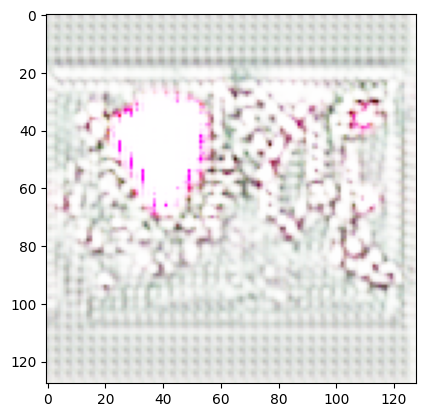

In [36]:

start_epoch = load_checkpoint(G, G_sketch, DA, DB, opt_G, opt_G_sketch, opt_DA, opt_DB, "/content/drive/MyDrive/checkpoint_epoch_9.pth")

def load_image(image_path, img_size=128):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(image).unsqueeze(0)


test_image_path = "/content/danbooru-sketch-pair-128x/color/sketch/0000/100000.png"
test_image = load_image(test_image_path).to(device)


test_image_path2 = "/content/danbooru-sketch-pair-128x/color/src/0000/1001000.png"
test_image2 = load_image(test_image_path2).to(device)


G.eval()  # evaluation mode
with torch.no_grad():
    generated_image = G(test_image, test_image2)

#
generated_image = generated_image.squeeze().cpu().numpy().transpose(1, 2, 0)
plt.imshow((generated_image + 1) / 2)  # [-1, 1] range to [0, 1]
plt.imshow(generated_image)
plt.show()



##Student

In [ ]:


def load_image(image_path, img_size=128):
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    return transform(image).unsqueeze(0)


test_image_path = "/content/drive/MyDrive/input/327.jpg"
test_image = load_image(test_image_path).to(device)


test_image_path2 = "/content/drive/MyDrive/output/350.jpg"
test_image2 = load_image(test_image_path2).to(device)


G_student.eval()  # evaluation mode
with torch.no_grad():
    generated_image = G_student(test_image, test_image2)

#
generated_image = generated_image.squeeze().cpu().numpy().transpose(1, 2, 0)
plt.imshow((generated_image + 1) / 2)  # [-1, 1] range to [0, 1]
#plt.imshow(generated_image)
plt.show()



# Style Transfer is not happening!